<h1 style="text-align:center;">Building makemore (III) : Activations & Gradients, BatchNorm</h1>


Useful links:
- [Kaiming init paper](https://arxiv.org/pdf/1502.01852.pdf)
- [BatchNorm paper](https://arxiv.org/pdf/1502.03167.pdf)
- [Bengio et al. 2003 MLP language model paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- [Good paper illustrating some of the problems with batchnorm in practice](https://arxiv.org/pdf/2105.07576.pdf)

# Loading the libraries and dataset

In [24]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

# print first 8words
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))

# Encoder : convert string to integer
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
print(f"The encoder (string to integer) that we're going to work with is :\n{stoi}\n")

# Decoder : convert integer to string
itos = {i:s for s,i in stoi.items()}
print(f"The decoder (integer to string) that we're going to work with is :\n{itos}")

# Vocabulary size
vocab_size = len(itos)

print(f"The vocabulary of size {len(itos)} we're working with is :\n{itos.values()}\n")

The encoder (string to integer) that we're going to work with is :
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}

The decoder (integer to string) that we're going to work with is :
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
The vocabulary of size 27 we're working with is :
dict_values(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '.'])



In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    """Takes a list of some words and builds the arrays X and Y
    for those words only"""
    
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size   # initial context is 3 dots '...'
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    # convert the lists into toch tensors
    X = torch.tensor(X)    # contexts
    Y = torch.tensor(Y)    # indexes of the ground truths
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(42)
random.shuffle(words)      # Shuffling the words
n1 = int(0.8*len(words))   # length of the training data (80%)
n2 = int(0.9*len(words))   # length of validation data (10%), and the remaigning 10% is for testing

# Building training, validation and testing datasets
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Batch Normalization

In neural networks, particularly in the context of Batch Normalization (BN), the term **"feature's activation"** refers to the output of a neuron or a set of neurons in a layer. Let's break down this concept:

**Neuron Activation :** Each neuron in a neural network computes a weighted sum of its inputs, applies an activation function to the sum, and produces an output. This output is often referred to as the activation of the neuron.

**Feature:** In the context of neural networks, a feature typically refers to a specific aspect or characteristic of the input data that the network is trained to detect or represent. For example, in an image classification task, features could represent shapes, textures, or patterns present in the images.

**Feature's Activation:** When we talk about the activation of a feature, we're referring to the output of neurons in a layer that are responsible for detecting or representing that particular feature. Each neuron's output contributes to the activation of the feature.

In Batch Normalization, the **"feature's activation"** specifically refers to the output of neurons in a layer after applying the normalization process. 

*  **Batch Normalization** : During training, Batch Normalization normalizes the activations of each feature across the mini-batch, making them have zero mean and unit variance (i.e. making them $\mathcal{N}(0,1)$-distributed). This normalization process helps in stabilizing the training process and accelerating convergence by reducing internal covariate shift.

$$BN(x_d) = \frac{x_d - \mu}{\sqrt{\sigma^2 +\varepsilon}}.\gamma + \beta$$

Where :

* **$d$ :** The number of features
* **$x_d$ :** The input
* **$\mu$, $\sigma$ :** The mean and standard deviation
* **$\varepsilon$ :** is a small constant (to avoid division by zero)
* **$\gamma$ :** The gain, it's a learnable scaler parameter 
* **$\beta$ :** The bias, it's a learnable shift parameter

So, when we mention "feature's activation" in the context of Batch Normalization, we're referring to the normalized output of neurons in a layer, where each feature corresponds to a specific aspect or characteristic of the input data.

* **Batch normalization gain ($\gamma$)** `bngain`: This parameter represents the scale factor of the Batch Normalization layer. It is used to scale the normalized inputs. In other words, it allows the model to learn the optimal scaling for each feature.

* **Batch normalization bias ($\beta$)** `bnbias`: This parameter represents the bias term of the Batch Normalization layer. It is added to the normalized inputs. Similar to $\gamma$, it allows the model to learn the optimal bias for each feature.

* **Batch normalization mean running** `bnmean_running`: This parameter represents the running mean of the Batch Normalization layer. During training, the mean of each feature's activation is computed for each mini-batch. The running mean is an exponential moving average of these means across all mini-batches seen during training. It is used during inference to normalize inputs consistently.

* **Batch normalization standard deviation running** `bnstd_running`: This parameter represents the running standard deviation of the Batch Normalization layer. Similar to `bnmean_running`, it computes the running standard deviation of each feature's activation across mini-batches during training. It is used during inference to normalize inputs consistently.

In batch normalization, the **BN mean running** and **BN standard deviation running** are used to keep track of the running averages of the mean and standard deviation computed during training. This is important because during the training process, the mean and standard deviation of each batch **can fluctuate**, and using the running averages helps to stabilize the training process. Here's why they are used :

* **Normalization :** Batch normalization aims to normalize the activations of each layer by subtracting the mean and dividing by the standard deviation. This helps to stabilize and accelerate the training process by ensuring that the inputs to each layer are within a similar range.

* **Training Stability :** During training, the statistics (mean and standard deviation) of each batch can vary, especially in the initial stages when the model is still learning. By using running averages of the mean and standard deviation, the normalization process becomes more stable, as it smooths out these variations.

* **Inference :** During inference (i.e., when making predictions on new data), we usually don't have access to batches of data to compute the mean and standard deviation. Instead, we use the running averages that were computed during training. This ensures consistency between training and inference and helps the model generalize better to unseen data.

# Building the MLP model

In [6]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(25101989)                    # for reproducibility
C  = torch.randn((vocab_size, n_embd), generator=g)   # embedding table shape(27, 10)

# hidden layer :
# Weight matrix shape(30, 200)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2 
#b1 = torch.randn(n_hidden, generator=g) * 0.01  # Bias vector shape(200)

# output layer :
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01  # shape(200, 27)
b2 = torch.randn(vocab_size, generator=g) * 0   # shape(27)  

# BatchNorm parameters : initialization 
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# model's (learnable) parameters
parameters = [C, W1, W2, b2, bngain, bnbias]

# number of parameters in total
print(sum(p.nelement() for p in parameters)) 

# specifiying whether gradients should be computed for a particular tensor during backpropagation 
for p in parameters:
    p.requires_grad = True

12097


# Training the MLP model

In [7]:
# same optimization as last time
max_steps = 200000   # max iteration
batch_size = 32      # context size
lossi = []           # list containing the log(10)-loss from each iteration

for i in range(max_steps):
    
    # minibatch construct
    # generating 32 random indeces of rows from Xtr
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)    #shape(32,)
    # Extracting 32 random rows from Xtr by using the indeces in ix
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y   # Shapes : Xb(32, 3) Yb(32) 
  

    # forward pass
    emb = C[Xb] # embed each character from each row of Xb ; shape (32,3,10) = (B,T,C)
    embcat = emb.view(emb.shape[0], -1) # (Flattening for each example from the batch) concatenate the vectors ; shape(32,30)
    # Linear layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation : (32,30)@(30,200)---->(32,200) 
    # BatchNorm layer (we normalize before activation)
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)   # without keepdim= T : shape(200), with keepdim=T : shape(1,200)
    bnstdi = hpreact.std(0, keepdim=True)     # shape(1,200)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias  # shape(32,200)
    with torch.no_grad(): # disabling gradient computation for 'bnmean_running' and 'bnstd_running'
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani   # shape(1,200)
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi      # shape(1,200)
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer # shape(32,200)
    logits = h @ W2 + b2 # output layer   # shape(32,200) @ shape(200, 27) + shape(27)---Pytorch broadcasting---> (32,27)
    loss = F.cross_entropy(logits, Yb) # loss function
  

    # backward pass
    for p in parameters:
        p.grad = None  # set the grad to zero in Pytorch
    loss.backward()  # populate the gradients
  

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad         # updating the parameter 

        
    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

      0/ 200000: 3.2789
  10000/ 200000: 2.2676
  20000/ 200000: 2.3727
  30000/ 200000: 2.1274
  40000/ 200000: 2.0793
  50000/ 200000: 2.2795
  60000/ 200000: 2.0513
  70000/ 200000: 2.4825
  80000/ 200000: 2.0123
  90000/ 200000: 2.9925
 100000/ 200000: 2.5253
 110000/ 200000: 2.2712
 120000/ 200000: 2.2949
 130000/ 200000: 2.0305
 140000/ 200000: 2.1097
 150000/ 200000: 2.3965
 160000/ 200000: 2.2720
 170000/ 200000: 1.8984
 180000/ 200000: 2.2429
 190000/ 200000: 1.9301


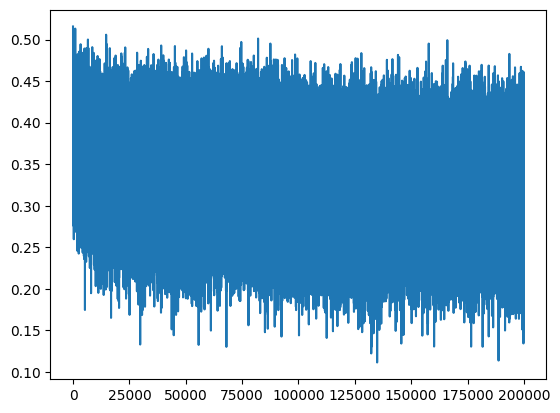

In [14]:
# Plotting the losses (y-axis) versus the steps i (x-axis)
plt.plot(lossi);


In [ ]:
plt.plot(lossi);

# Calibrating the batch normalization

**Calibrating the batch normalization** at the end of training refers to the process of fine-tuning the normalization parameters (mean and standard deviation) to better match the statistics of the entire training dataset. This step is often performed after the model has been trained using mini-batches of data.

Here's what it involves:

* **Evaluation Data :** Once the model has been trained, a separate dataset, often called the validation or evaluation dataset, is used.

* **Normalization Statistics :** For each layer with batch normalization, the mean and standard deviation of the activation values over the entire evaluation dataset are computed.

* **Update Parameters :** These computed mean and standard deviation values are then used to update the parameters of batch normalization layers. This ensures that the normalization is calibrated to the statistics of the entire dataset rather than just the individual mini-batches used during training.

* **Freezing :** After calibration, the parameters of the batch normalization layers are typically frozen, meaning they are no longer updated during further training or inference.

Calibrating batch normalization at the end of training helps to improve the generalization performance of the model by ensuring that the normalization is better aligned with the overall distribution of the data. It can lead to better performance and stability, especially when the distribution of the training data is significantly different from the distribution of the individual mini-batches used during training.

In [15]:
# calibrate the batch norm at the end of training

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]                          # shape(182625, 3, 10)
    embcat = emb.view(emb.shape[0], -1)   # (Flattening for each example from the batch) concatenate by reshaping to (182625,30)  
    hpreact = embcat @ W1 # + b1          # (182625,30)@(182625,200)---->(182625,200)
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)  # shape(1,200)
    bnstd = hpreact.std(0, keepdim=True)    # shape(1,200)

In [16]:
@torch.no_grad() # this decorator disables gradient tracking for 'split_loss()' function
def split_loss(split):
    """returns the loss given a split (which can be 'train', 'val' or 'test')"""
    
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd), N is x.shape[0]
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 # + b1  # (N, n_hidden)
    #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias     # (N, n_hidden)
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.068769693374634
val 2.1111230850219727


## loss log

### original:
train 2.1245384216308594
val   2.168196439743042

### fix softmax confidently wrong:
train 2.07
val   2.13

### fix tanh layer too saturated at init:
train 2.0355966091156006
val   2.1026785373687744

### use semi-principled "kaiming init" instead of hacky init:
train 2.0376641750335693
val   2.106989622116089

### add batch norm layer
train 2.068769693374634
val 2.1111230850219727


# Summary 
## Pytorchifying the code 

Let's make the code a little bit more simalar to Pytorch.

* **Fan-in:** The fan-in of a neuron or layer is the number of input connections it has. In other words, it represents the number of weights that contribute to the computation performed by that neuron or layer.

* **Fan-out:** The fan-out of a neuron or layer is the number of output connections it has. It represents the number of connections through which the computed result from that neuron or layer is passed to the next layer.

Let's train a deeper network, the classes we create here are the same API as `nn.Module` in Pytorch :

In [17]:

class Linear: # similar to 'torch.nn.Linear' class representing a linear transformation layer
  
  def __init__(self, fan_in, fan_out, bias=True):
        # initializations :
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5   # note: kaiming init weight matrix is of shape (fan_in, fan_out)
        self.bias = torch.zeros(fan_out) if bias else None       # shape (fan_out)
  
  def __call__(self, x):
        self.out = x @ self.weight   # (x.shape[0], 'x.shape[1]=fan_in') @ (fan_in,fan_out) -----> (x.shape[0],fan_out)
        if self.bias is not None:
            self.out += self.bias #(x.shape[0],fan_out) + (fan_out)----broadcasting--->(x.shape[0],fan_out) + (x.shape[0],fan_out)----> (x.shape[0],fan_out)
        return self.out  #(x.shape[0],fan_out)
  
  def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])   # building a list of parameters



# -----------------------------------------------------------------------------------------------
class BatchNorm1d:  # similar to 'torch.nn.BatchNorm1d' class representing a batch normalization layer designed for 1-dimensional input.
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps                        #  epsilon : a value added to the denominator for numerical stability
        self.momentum = momentum              # the value used for the 'running_mean' and 'running_var' computation
        self.training = True                  # if we're training = True, otherwise = False
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)          # BN gain : dim is number of neurones in the previous hidden layer
        self.beta = torch.zeros(dim)          # BN bias
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:  # during training
            xmean = x.mean(0, keepdim=True) # batch mean : shape(1, x.shape[1])
            xvar = x.var(0, keepdim=True) # batch variance
        else: # during evaluation or inference (self.training = False)
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(self.eps + xvar) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta   
        # update the buffers
        if self.training: # during training
            with torch.no_grad(): # disabling gradient computation for 'running_mean' and 'running_var'
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]   # list of learnable parameters



# -----------------------------------------------------------------------------------------------
class Tanh:
    
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10                                       # the dimensionality of the character embedding vectors
n_hidden = 100                                    # the number of neurons in the hidden layers of the MLP
g = torch.Generator().manual_seed(25101989)       # for reproducibility

# MLP STRUCTURE :

## EMBEDDING LAYER : tokens ----> shape(batch_size, block_size, n_embd)
## CONCATENATION (FLATTENING FOR EACH EXAMPLE FROM THE BATCH) : shape(batch_size, block_size, n_embd) -----> shape(batch_size, block_size * n_embd)
## 1ST LINEAR COMBINATION : shape(batch_size, n_embd * block_size) ----(.@W+b)----> shape(batch_size, n_hidden)
## 1ST BATCHNORM1D : shape(batch_size, n_hidden) ---Normalizing the outputs from 1st layer--> shape(batch_size, n_hidden) 
## 1ST NON_LINEAR : shape(batch_size, n_hidden) ---tanh(.)--> shape(batch_size, n_hidden)
##...
## 6TH LINEAR COMBINATION : shape(batch_size, n_hidden) -----> shape(batch_size, vocab_size)
## 6TH BATCHNORM1D : shape(batch_size, vocab_size)--------> shape(batch_size, vocab_size)


# Embedding Table : shape(vocab_size, n_embd)
C = torch.randn((vocab_size, n_embd), generator=g)

# layers : 17 layer 
layers = [ 
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

# with bias, and without BN :
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
    # last layer (BatchNorm1d(vocab_size)) : make less confident
    layers[-1].gamma *= 0.1
    #layers[-1].weight *= 0.1 # with bias, and without BN 
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 #5/3

# build a (learnable) parameters list that contains all the model parameters   
parameters = [C] + [p for layer in layers for p in layer.parameters()]

# number of parameters in total
print(sum(p.nelement() for p in parameters)) 

for p in parameters:
    p.requires_grad = True

47024


## Training the MLP model

In [18]:
# same optimization as last time : look above to understand each line
max_steps = 200000
batch_size = 32
lossi = []
ud = []  # update

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # flattening for each example from the batch : concatenate the vectors
    for layer in layers :
        x = layer(x)   # apply layers sequentially
    loss = F.cross_entropy(x, Yb) # loss function (softmax layer)
  
    # backward pass
    for layer in layers :
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters :
        p.grad = None  # set the grad to zero in Pytorch
    loss.backward()
  
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters :
        p.data += -lr * p.grad  # update the parameters

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad() :
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])   #update
    
    #if i >= 1000:
    #  break # AFTER_DEBUG: would take out obviously to run full optimization 

      0/ 200000: 3.3002
  10000/ 200000: 2.2015
  20000/ 200000: 2.1756
  30000/ 200000: 2.2501
  40000/ 200000: 2.2451
  50000/ 200000: 1.8510
  60000/ 200000: 1.9193
  70000/ 200000: 2.0629
  80000/ 200000: 1.8311
  90000/ 200000: 1.6286
 100000/ 200000: 2.1219
 110000/ 200000: 2.1365
 120000/ 200000: 2.1332
 130000/ 200000: 1.8383
 140000/ 200000: 1.7755
 150000/ 200000: 2.1090
 160000/ 200000: 1.9486
 170000/ 200000: 2.5830
 180000/ 200000: 1.8799
 190000/ 200000: 2.0451


* **Saturation of activation function :** The activation function may saturate, meaning it outputs values close to its asymptotic limites ($0$ or $1$ for **sigmoid**, and $-1$ or $1$ for **tanh**) over a large range of inputs. This can lead to regions of the input space where the gradient is close to $0$, resulting in slow learning or no learning at all.

Let's look at the activation distributions :

layer 2 (      Tanh): mean -0.03, std 0.71, saturated: 17.88%
layer 5 (      Tanh): mean +0.01, std 0.76, saturated: 20.28%
layer 8 (      Tanh): mean +0.01, std 0.77, saturated: 21.50%
layer 11 (      Tanh): mean +0.03, std 0.80, saturated: 23.34%
layer 14 (      Tanh): mean -0.00, std 0.80, saturated: 24.09%


Text(0.5, 1.0, 'activation distribution')

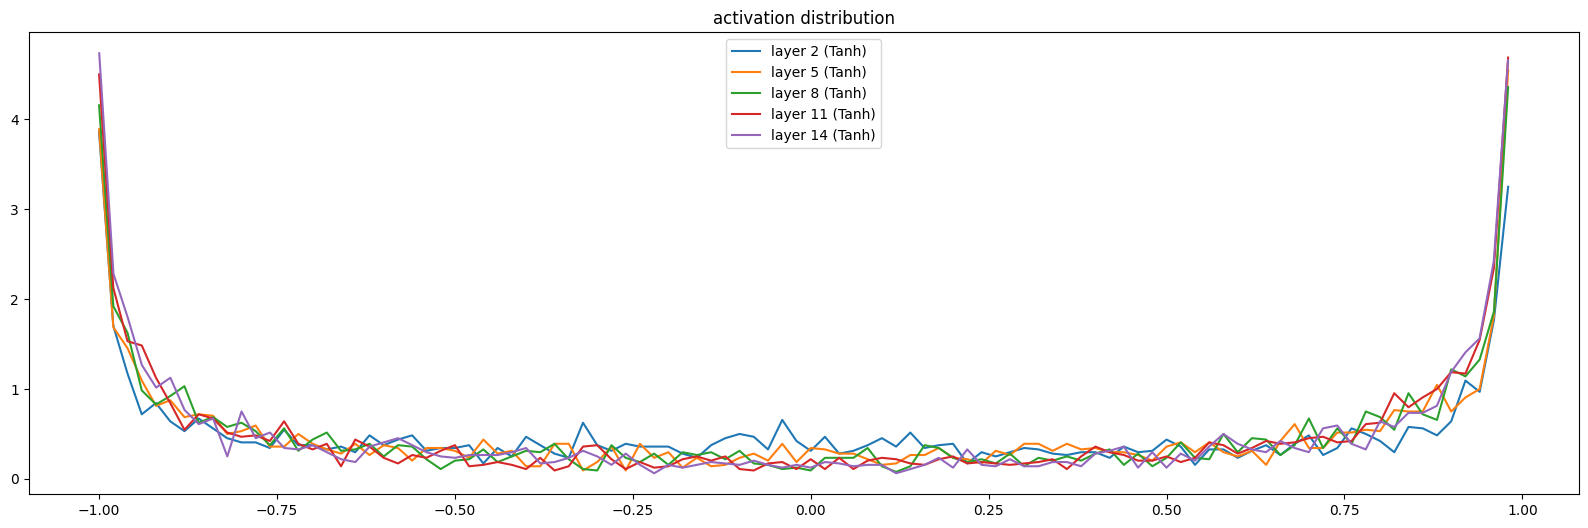

In [19]:
# visualize histograms of the forward pass activations in the tanh layers
plt.figure(figsize = (20, 6)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer (the softmax layer)
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

We are looking at how many values in these tensors `hy` take on any of the values of the X-axis `hx`. Let's take a lookt at the gradient distribution :

layer 2 (      Tanh): mean -0.000000, std 3.619866e-03
layer 5 (      Tanh): mean -0.000000, std 3.600612e-03
layer 8 (      Tanh): mean -0.000000, std 3.314567e-03
layer 11 (      Tanh): mean +0.000000, std 3.244611e-03
layer 14 (      Tanh): mean +0.000000, std 3.365182e-03


Text(0.5, 1.0, 'gradient distribution')

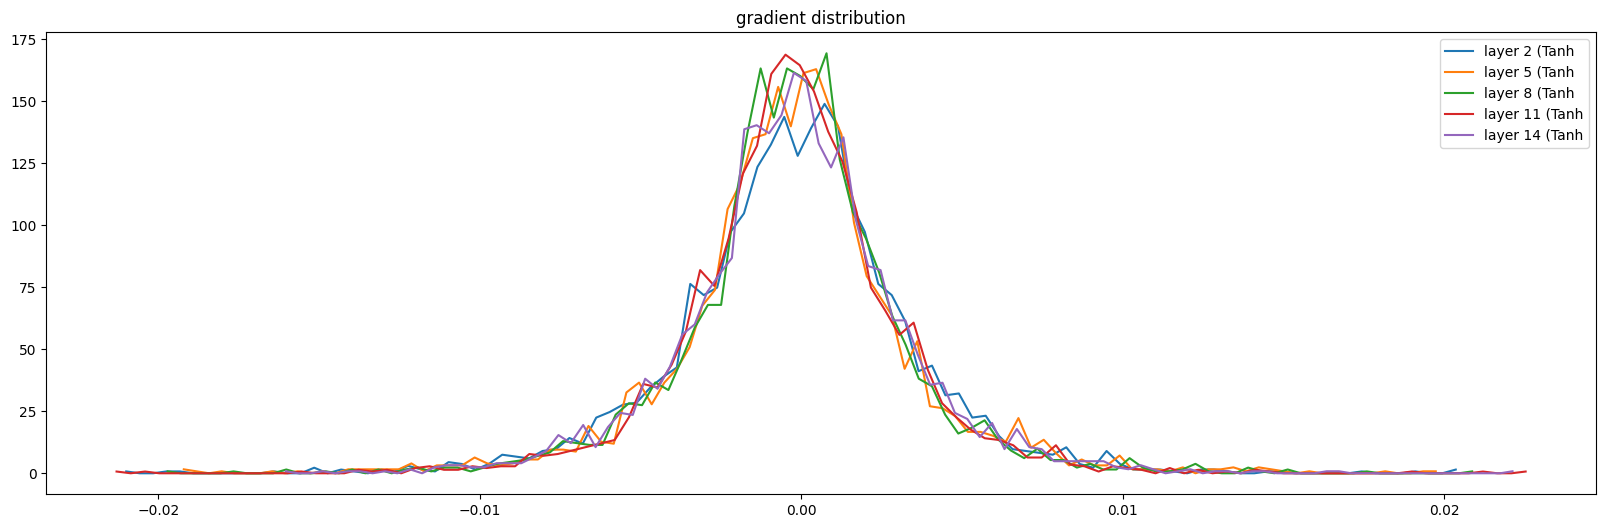

In [20]:
# visualize histograms
plt.figure(figsize = (20, 6)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

Now, let's take a look at the weights gradient distribution :

weight   (27, 10) | mean -0.000000 | std 1.481822e-02 | grad:data ratio 1.373578e-02
weight  (30, 100) | mean -0.000173 | std 8.552107e-03 | grad:data ratio 2.127311e-02
weight (100, 100) | mean +0.000039 | std 5.550995e-03 | grad:data ratio 2.302243e-02
weight (100, 100) | mean +0.000029 | std 5.628685e-03 | grad:data ratio 2.357803e-02
weight (100, 100) | mean -0.000019 | std 5.072246e-03 | grad:data ratio 2.198535e-02
weight (100, 100) | mean -0.000138 | std 4.781324e-03 | grad:data ratio 2.227914e-02
weight  (100, 27) | mean +0.000034 | std 8.226858e-03 | grad:data ratio 2.356319e-02


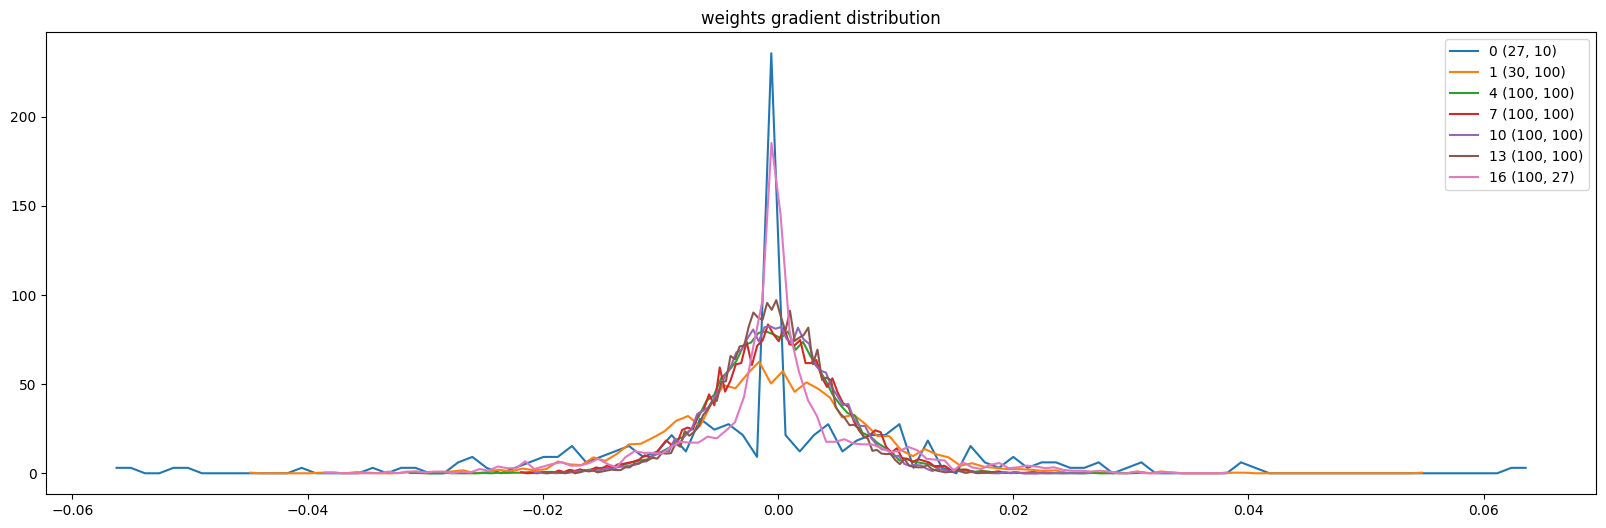

In [21]:
# visualize histograms
plt.figure(figsize = (20, 6)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # only restricting it to 2d params (basically the weights of these linear layers)
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

In [23]:
len(ud)

200000

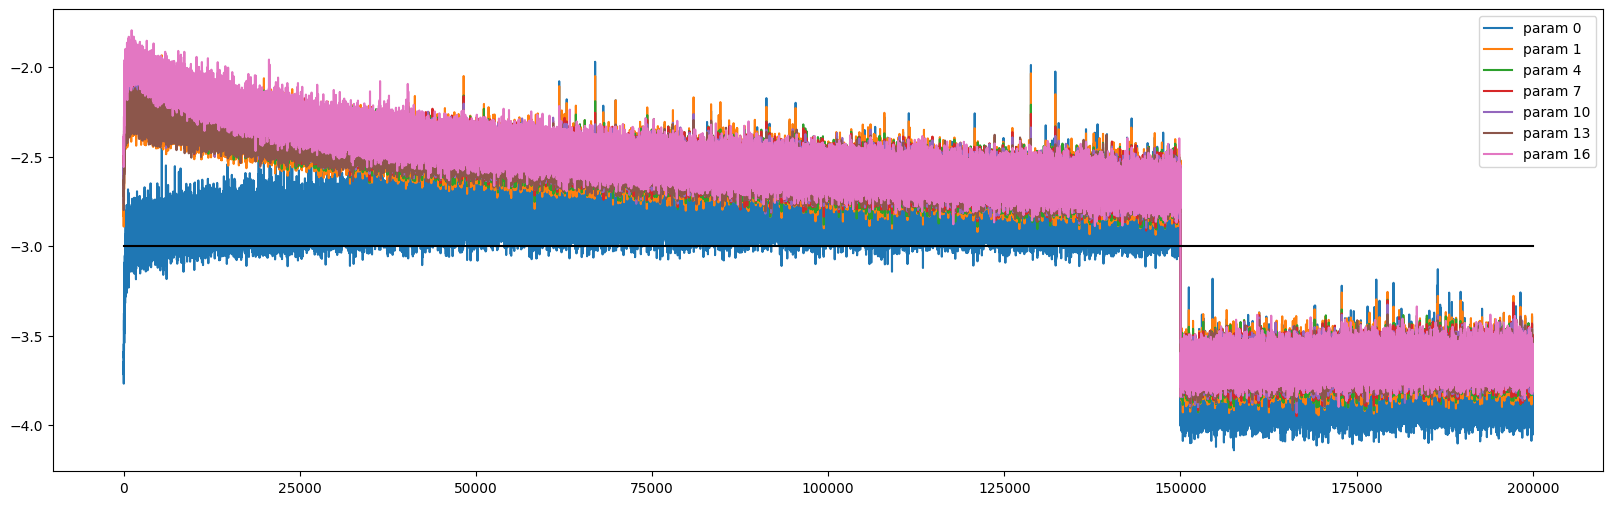

In [25]:
plt.figure(figsize = (20, 6))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:  # retaining the weights
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # 'k' means draw a black line, these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


If it's bellow -3, usually that means that the parameters are not training fast enough, and we need to bump up the learning rate.

# Evaluating the MLP model

In [26]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    """given the 'split' ('train' or 'val' or 'test') the function will apply the model
    on the given 'split' dataset and return the loss"""
    
    x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# put layers into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')

train 1.9999555349349976
val 2.0804603099823


# Generating Names

In [28]:
# sample from the model
g = torch.Generator().manual_seed(25101989 + 10)

for _ in range(20):  # generating 20 names
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

abbritt.
aidia.
viva.
mika.
endella.
marta.
candallipt.
dakoedelyn.
treliah.
dael.
lyng.
reva.
osy.
kayella.
aiah.
dre.
jacoplie.
kand.
alon.
dagrane.


In [38]:
# DONE; BONUS content below, not covered

In [33]:
# BatchNorm forward pass as a widget

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
    
    g = torch.Generator().manual_seed(25101989+1)
    x = torch.randn(5, generator = g) * 5
    x[0] = x0 # override the 0th example with the slider
    mu = x.mean()
    sig = x.std()
    y = (x - mu)/sig

    plt.figure(figsize = (10, 5))
    # plot 0
    plt.plot([-6,6], [0,0], 'k')  # black shape
    # plot the mean and std
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b') # blue shape
    xx = np.linspace(-6, 6, 100)
    plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')  # red shape
    # plot little lines connecting input and output
    for i in range(len(x)):
        plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
    # plot the input and output values
    plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)  # blue dots
    plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100) # red dots
    plt.xlim(-6, 6)
    # title
    plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [36]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(25101989)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9623281359672546
b std: 0.9998757839202881
c std: 30.3967227935791
-----
c grad std: 1.0276267528533936
a grad std: 33.3276481628418
b grad std: 0.9885414838790894


In [37]:
# Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(25101989)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer ---
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# ----
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9623281359672546
w std:  0.9998757839202881
x std:  30.3967227935791
out std:  1.0
------
out grad std:  1.0276267528533936
x grad std:  0.03380375728011131
w grad std:  0.03250984475016594
inp grad std:  1.094513177871704


[Younes Dahami](https://www.linkedin.com/in/dahami/)